In [1]:
pip install ta

  Using cached ta-0.7.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c quantopian ta-lib 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - ta-lib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py38h578d9bd_1         143 KB  conda-forge
    libta-lib-0.4.0            |       h516909a_0         503 KB  conda-forge
    openssl-1.1.1k             |       h7f98852_0         2.1 MB  conda-forge
    ta-lib-0.4.19              |   py38h0b5ebd8_2         424 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

  libta-lib          conda-forge/linux-64::libta-lib-0.4.0-h516909a_0
  t

In [3]:
pip install yfinance

  Using cached yfinance-0.1.59-py2.py3-none-any.whl
  Using cached multitasking-0.0.9-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
import yfinance as yf
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands



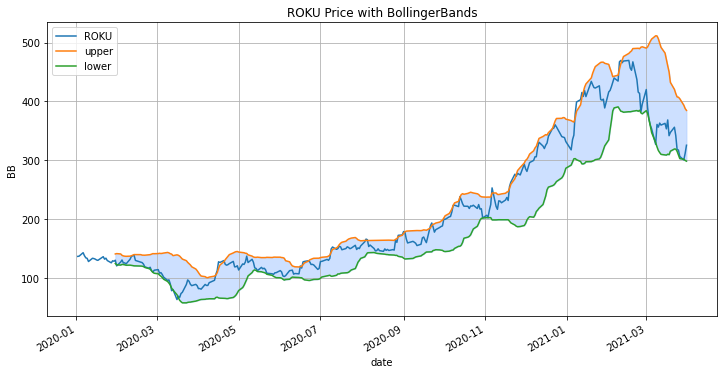

In [445]:
roku = yf.Ticker("ROKU")
df = roku.history(start="2020-01-01", end='2021-04-01')
df = df.loc[:,['Close']]
# rename the column header with symbol name
symbol = 'ROKU'
df = df.rename(columns={'Close': symbol})

# calculate Simple Moving Average with 20 days window
sma = df.rolling(window=20).mean()
# calculate the standard deviation
std = df.rolling(window=20).std()

upper_band = sma + 2 * std
upper_band = upper_band.rename(columns={symbol: 'upper'})
lower_band = sma - 2 * std
lower_band = lower_band.rename(columns={symbol: 'lower'})

df = df.join(upper_band).join(lower_band)
ax = df.plot(title='{} Price with BollingerBands'.format(symbol),figsize=(12,6))
ax.fill_between(df.index, lower_band['lower'], upper_band['upper'], color='#ADCCFF', alpha=0.6)
ax.grid()
ax.set_xlabel('date')
ax.set_ylabel('BB')
plt.show()

In [424]:
roku = yf.Ticker("ROKU")
df = roku.history(start="2020-01-01", end='2020-09-04')
df = df.iloc[:,[1,2,3,4]]
df.head()

,High,Low,Close,Volume
Date,,,,
2020-01-02,137.330002,133.580002,137.100006,9924400
2020-01-03,138.889999,134.000000,137.509995,8637000
2020-01-06,144.550003,135.755005,143.369995,14422000
2020-01-07,144.229996,137.910004,138.190002,11574700
2020-01-08,137.929993,132.850006,134.639999,11291300


In [425]:
# ADX/+-DL calculation
#pos dm: today's high-yesterday's high
df1 = df
df1['hi-lo'] = df['High'] - df['Low']
#computing the difference between today's high price and yesterday's closing price
df1['high-close'] = abs(df['High'] - df['Close'].shift(1))
##computing the difference between today's low price and yesterday's closing price
df1['low-close'] = abs(df['Low'] - df['Close'].shift(1))
#getting the true range which is just the largest value of the 3 previous columns
df1['true_range'] = df[["hi-lo","high-close","low-close"]].apply(max,axis=1)
df1.dropna(inplace=True)
df1.head()

,High,Low,Close,Volume,hi-lo,high-close,low-close,true_range
Date,,,,,,,,
2020-01-03,138.889999,134.000000,137.509995,8637000,4.889999,1.789993,3.100006,4.889999
2020-01-06,144.550003,135.755005,143.369995,14422000,8.794998,7.040009,1.754990,8.794998
2020-01-07,144.229996,137.910004,138.190002,11574700,6.319992,0.860001,5.459991,6.319992
2020-01-08,137.929993,132.850006,134.639999,11291300,5.079987,0.260010,5.339996,5.339996
2020-01-09,138.770004,131.240005,133.789993,12630700,7.529999,4.130005,3.399994,7.529999


In [426]:
# pos DM is if (Today's high - Yesterday's High) > (Yesterday's Low - Today's Low), then
# +DM = (Today's high - Yesterday's High), Otherwise it's 0 
def pos_DM(x,y):
    DM_plus = np.zeros(170)
    for i in np.arange(0,len(df['High']),1):
        if (x[i]-x[i-1] > y[i-1]-y[i]):
            DM_plus[i] = (x[i]-x[i-1])
        else:
            DM_plus[i] = 0
    return(DM_plus)
pos_DM(df['High'],df['Low'])
df1['pos_DM'] = pos_DM(df['High'],df['Low'])

# If (Yesterday's Low - Today's Low) >(Today's high - Yesterday's High), then
# -DM = (Yesterday's Low - Today's Low) Otherwise it's 0.
def neg_DM(x,y):
    DM_neg = np.zeros(170)
    for i in np.arange(0,len(df['Low']),1):
        if (y[i-1]-y[i] > x[i]-x[i-1]):
            DM_neg[i] = (y[i-1]-y[i])
        else:
            DM_neg[i] = 0
    DM_neg[0]=0 #first day has no data. If not setting to 0 it will subtract from last day instead
    return(DM_neg)
neg_DM(df['High'],df['Low'])
df1['neg_DM'] = neg_DM(df['High'],df['Low'])


ATR = np.zeros(170)
ATR[13] = np.mean(df1['true_range'][0:13])
for i in range(14,170):
    ATR[i] = (ATR[i-1]*13 + df1['true_range'][i])/14
df1['ATR'] = ATR
df1

,High,Low,Close,Volume,hi-lo,high-close,low-close,true_range,pos_DM,neg_DM,ATR
Date,,,,,,,,,,,
2020-01-03,138.889999,134.000000,137.509995,8637000,4.889999,1.789993,3.100006,4.889999,0.000000,0.000000,0.000000
2020-01-06,144.550003,135.755005,143.369995,14422000,8.794998,7.040009,1.754990,8.794998,5.660004,0.000000,0.000000
2020-01-07,144.229996,137.910004,138.190002,11574700,6.319992,0.860001,5.459991,6.319992,-0.320007,0.000000,0.000000
2020-01-08,137.929993,132.850006,134.639999,11291300,5.079987,0.260010,5.339996,5.339996,0.000000,5.059998,0.000000
2020-01-09,138.770004,131.240005,133.789993,12630700,7.529999,4.130005,3.399994,7.529999,0.000000,1.610001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-28,177.539993,161.500000,172.850006,26700100,16.039993,16.569992,0.529999,16.569992,11.389999,0.000000,8.251422
2020-08-31,175.509995,168.059998,173.479996,10227100,7.449997,2.659988,4.790009,7.449997,-2.029999,0.000000,8.194177
2020-09-01,185.440002,176.630005,179.270004,10561500,8.809998,11.960007,3.150009,11.960007,9.930008,0.000000,8.463165


In [437]:
#First 14TR = sum of first 14 TR readings.
#Next 14TR value = first(prior) 14TR - (prior 14TR/14) + current TR

#smooth_TR = np.zeros(170)
#smooth_TR = df['true_range'].rolling(window=14).sum()

#smooth_TR_real=np.zeros(170)
#for i in range(14,170):
#    smooth_TR_real[i] = smooth_TR[i-1] - smooth_TR[i-1]/14 + smooth_TR[i] 

#same approach for posDM and negDM
#smooth_posDM = df['pos_DM'].rolling(window=14).sum()
smooth_posDM_real = np.zeros(170)
smooth_posDM_real[13]=np.sum(df1['pos_DM'][0:13])
for i in range(14,170):
    smooth_posDM_real[i] = smooth_posDM_real[i-1] - smooth_posDM_real[i-1]/14 + df1['pos_DM'][i]

#smooth_negDM = df['neg_DM'].rolling(window=14).sum()
smooth_negDM_real = np.zeros(170)
smooth_negDM_real[13]=np.sum(df1['neg_DM'][0:13])
for i in range(14,170):
    smooth_negDM_real[i] = smooth_negDM_real[i-1] - smooth_negDM_real[i-1]/14 + df1['neg_DM'][i]

#smooth_ATR = df1['ATR'].rolling(window=14).sum()
smooth_ATR_real = np.zeros(170)
smooth_ATR_real[13]=np.sum(df1['ATR'][0:13])
for i in range(14,170):
    smooth_ATR_real[i] = smooth_ATR_real[i-1] - smooth_ATR_real[i-1]/14 + ATR[i]
df2 = df1
df2['smooth_posDM'] = smooth_posDM_real
df2['smooth_negDM'] = smooth_negDM_real
df2['smooth_ATR'] = smooth_ATR_real
df2 = df2.iloc[14:,[0,1,2,3,10,11,12,13]]
df2.head()

,High,Low,Close,Volume,ATR,smooth_posDM,smooth_negDM,smooth_ATR
Date,,,,,,,,
2020-01-24,135.660004,128.789993,130.089996,8488100,6.319642,17.057853,12.413570,6.319642
2020-01-27,128.516998,123.779999,126.209999,9239400,6.318953,15.839435,16.536881,12.187192
2020-01-28,130.289993,125.010002,129.610001,8173100,6.244742,16.481041,15.355675,17.561420
2020-01-29,131.800003,128.619995,128.880005,5805200,6.025832,16.813834,14.258841,22.332865
2020-01-30,130.880005,126.800003,130.639999,4472500,5.886844,15.612846,15.060345,26.624505


In [438]:
posDI = df2['smooth_posDM']/df2['smooth_ATR']*100
negDI = df2['smooth_negDM']/df2['smooth_ATR']*100

DMI = (abs(posDI-negDI))/(abs(posDI+negDI))*100
df3 = df2
df3['posDI'] = posDI
df3['negDI'] = negDI
df3['DMI'] = DMI

ADX = np.zeros(156)
ADX[13] = np.mean(df3['DMI'][0:13])
for i in range(14,156):
    ADX[i] = (ADX[i-1]*13 + DMI[i])/14

df3['ADX'] = ADX
df3 = df3.iloc[14:,[0,1,2,3,8,9,10,11]]
df3.head()

,High,Low,Close,Volume,posDI,negDI,DMI,ADX
Date,,,,,,,,
2020-02-13,141.710007,138.360001,139.050003,20641400,35.729586,23.089182,21.490426,12.066859
2020-02-14,151.199997,127.400002,130.250000,63567800,31.443306,37.846773,9.241535,11.865051
2020-02-18,133.550003,125.239998,127.150002,19434100,27.821327,36.778701,13.865899,12.007968
2020-02-19,131.600006,126.400002,126.559998,17247300,24.811976,31.102720,11.250609,11.953871
2020-02-20,127.790001,121.120003,124.080002,15397000,22.239405,35.337097,22.748328,12.724904


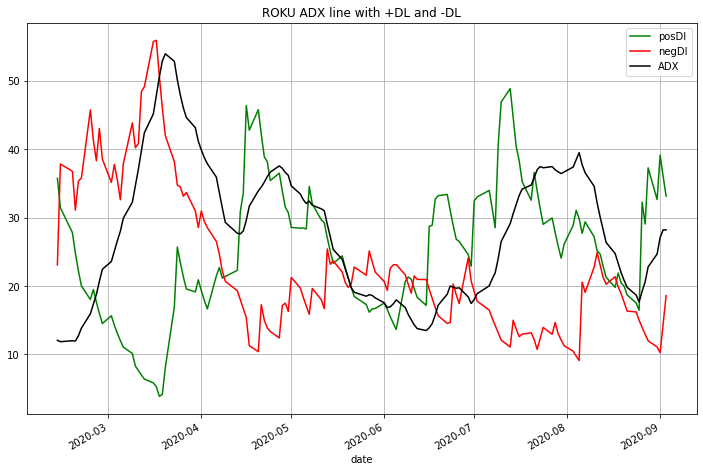

In [439]:
df4 = df3
df4 = df4.iloc[:,[4,5,7]]

ax = df4.plot(title='{} ADX line with +DL and -DL'.format(symbol),figsize=(12,8),color=("green","red","black"))
ax.grid()
ax.set_xlabel('date')
ax.set_ylabel('')
plt.show()

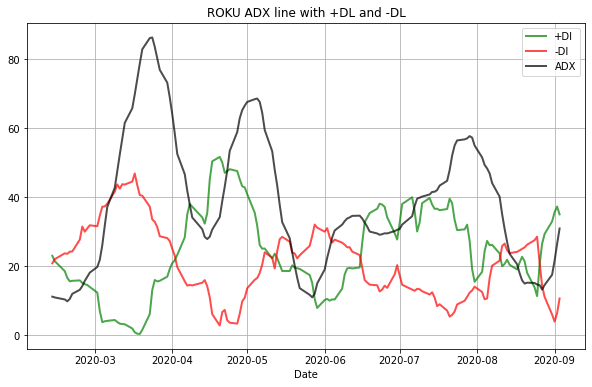

In [296]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df4['posDI'], label='+DI', color='green', alpha=0.8,linewidth=2)
ax.plot(df4['negDI'], label='-DI', color='red', alpha=0.8,linewidth=2)
ax.plot(df4['ADX'], label='ADX', color='Black', alpha=0.8,linewidth=2)
ax.set_title('{} ADX line with +DL and -DL'.format(symbol))
ax.set_xlabel('Date')
ax.set_ylabel('')
ax.legend()
ax.grid()
fig = ax.get_figure()

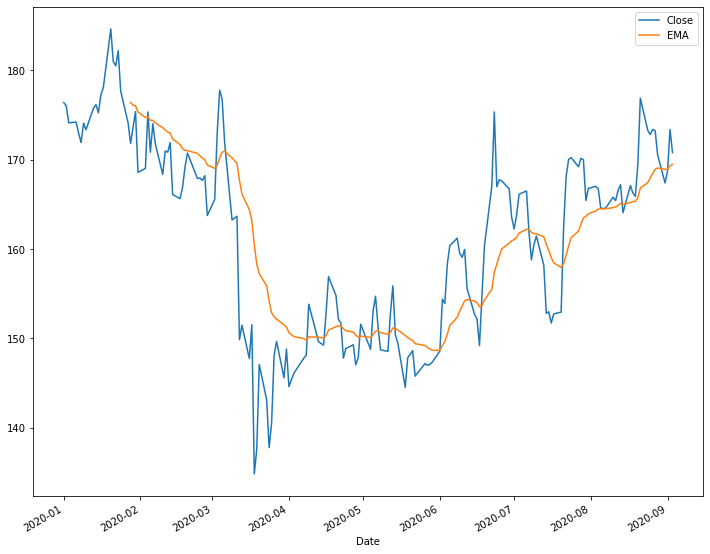

In [72]:
df['EMA'] = ta.EMA(df['Close'], timeperiod = 20)
df[['Close','EMA']].plot(figsize=(12,10))
plt.show()